# Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D,Concatenate
import tensorflow as tf
import keras
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib
path = 'C:\\Users\\saite\\Desktop\\sketch to image conversion using unet'


In [2]:
from IPython.display import Image

# Preprocessing

In [3]:
#image_id_list = train['image_id'].unique().tolist()
image_id_list = os.listdir(path+'\sketch')

In [4]:
#image_id_list = sum(image_id_list,[])
print(len(image_id_list),image_id_list)

85960 ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '000071.jpg',

# Hyperparameters    
- image size
- train path
- epochs
- validation size
- Generator Declaration

In [5]:
image_size = (218,178)
train_path = 'C:\\Users\\saite\\Desktop\\sketch to image conversion using unet'
epochs = 80


# Data Generator

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,ids,filepath,batch_size=16,image_size=(480,640),channels=3):
        self.ids=ids
        self.filepath=filepath
        self.batch_size=batch_size
        self.image_size=image_size
        self.channels=channels
        
    def __len__(self):
            return (len(self.ids)//self.batch_size)
        
    '''def __load__(self,id_name):
            img = cv2.imread(filepath+'/'+id_name,-1)
            img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
            return img'''
            
            
            
    def __getitem__(self,index):
            indexes = range(index*self.batch_size,index*self.batch_size+self.batch_size)
            
            ids_to_load = [self.ids[k] for k in indexes]
            X = self.__generate_x(ids_to_load)
            y = self.__generate_y(ids_to_load)
            l = []
            for i,m in enumerate(X):
                l.append(m.reshape(218,178,3))
            X = np.array(l)
            l = []
            for i,m in enumerate(y):
                l.append(m.reshape(218,178,3))
            y = np.array(l)
            return X,y
            
        
        
    def __generate_x(self,id_names):
            X = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                #print(self.filepath+'/sketch/'+id_n+'-sz1.jpg')
                img = cv2.imread(self.filepath+'\sketch\\'+id_n)
                '''plt.imshow(img)
                plt.show()'''
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                
                img = img.astype(np.float32)/255.
                
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                '''plt.imshow(img)
                plt.show()'''
                X[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return X
        
    def __generate_y(self,id_names):
            y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                img = cv2.imread(self.filepath+'\image\\'+id_n)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255.
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                '''plt.imshow(img)
                plt.show()'''
                y[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return y
             
        
        
        

# Sample plot of data

In [7]:
train_gen = DataGenerator(image_id_list[:int(len(image_id_list)*0.2)],train_path,batch_size=16,image_size=(178,218),channels=3)
val_gen = DataGenerator(image_id_list[int(len(image_id_list)*0.95):],train_path,batch_size=16,image_size=(178,218),channels=3)
test_gen = DataGenerator(image_id_list[int(len(image_id_list)*0.25):int(len(image_id_list)*0.90)],train_path,batch_size=16,image_size=(178,218),channels=3)

In [8]:

X,y = val_gen.__getitem__(1)
val_gen.__len__()
#train_gen.__len__()

268

In [9]:
X,y = train_gen.__getitem__(1)
train_gen.__len__()
print(len(X))
len(train_gen)

16


1074

In [10]:
len(image_id_list)

85960

In [11]:
cv2.imwrite('file.jpg',X[1]*255.)

True

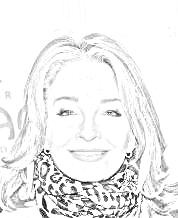

In [12]:
Image(filename='file.jpg')

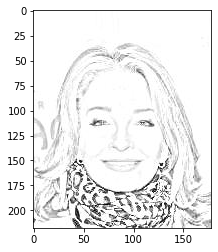

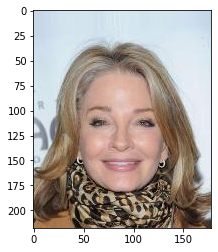

In [13]:
plt.imshow(X[1])
plt.show()
# plt.imsave('file.jpg',X[1])
plt.imshow(y[1])
plt.show()

# Loss Function

In [14]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Different Convolution block

In [15]:

def down_block(x,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    c = Conv2D(filters,kernel_size=kernel_size,padding=padding,strides=strides,activation=activation)(x)
#     c = tf.keras.layers.Dropout(0.2)(c)
    c = Conv2D(filters,kernel_size=kernel_size,padding=padding,strides=strides,activation=activation)(c)
    p = MaxPooling2D((2,2))(c)
    return c,p

def up_block(x,skip,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    us = UpSampling2D((2,2))(x)
    us = Concatenate()([us,skip])
    us = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(us)
#     us = tf.keras.layers.Dropout(0.2)(us)
    us = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(us)
    return us
    
def bottleneck(x,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    b = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(x)
#     b = tf.keras.layers.Dropout(0.2)(b)
    b = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(b)
    return b

# Unet Model

In [16]:
def Unet():
    f = [16,32,64,128,256]
    inputs = Input((image_size[0],image_size[1],3))
    
    c1,p1 = down_block(inputs,f[0])
    c2,p2 = down_block(p1,f[1])
    c3,p3 = down_block(p2,f[2])
    c4,p4 = down_block(p3,f[3])
    b = bottleneck(p4,f[4])
    u1 = up_block(b,c4,f[3])
    u2 = up_block(u1,c3,f[2])
    u3 = up_block(u2,c2,f[1])
    u4 = up_block(u3,c1,f[0])
    
    outputs = Conv2D(3,(1,1),padding='same',activation='sigmoid')(u4)
    
    model = Model(inputs,outputs)
    
    return model
    

# Training the Model

In [17]:
model = Unet()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[dice_loss,'accuracy'])
model.summary()
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
model.fit(train_gen,epochs = epochs,validation_data = val_gen,callbacks=[checkpoint])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 218, 178, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 218, 178, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_17 (Conv2D)             (None, 218, 178, 16  2320        ['conv2d_16[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 218, 178, 3)  51          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 1,962,659
Trainable params: 1,962,659
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
model.fit(train_gen,epochs = epochs,validation_data = val_gen,callbacks=[checkpoint])

Epoch 1/80
1074/1074 [==============================] - ETA: 0s - loss: 0.5957 - dice_loss: 0.4723 - accuracy: 0.7355
Epoch 1: loss improved from inf to 0.59573, saving model to best_model.hdf5
1074/1074 [==============================] - 4121s 4s/step - loss: 0.5957 - dice_loss: 0.4723 - accuracy: 0.7355 - val_loss: 0.5752 - val_dice_loss: 0.4590 - val_accuracy: 0.7583
Epoch 2/80
1074/1074 [==============================] - ETA: 0s - loss: 0.5448 - dice_loss: 0.4223 - accuracy: 0.7394
Epoch 2: loss improved from 0.59573 to 0.54483, saving model to best_model.hdf5
1074/1074 [==============================] - 4967s 5s/step - loss: 0.5448 - dice_loss: 0.4223 - accuracy: 0.7394 - val_loss: 0.5489 - val_dice_loss: 0.3882 - val_accuracy: 0.7518
Epoch 3/80
1074/1074 [==============================] - ETA: 0s - loss: 0.5273 - dice_loss: 0.4059 - accuracy: 0.7374
Epoch 3: loss improved from 0.54483 to 0.52726, saving model to best_model.hdf5
1074/1074 [==============================] - 4105s 4

Epoch 23/80
1074/1074 [==============================] - ETA: 0s - loss: 0.4921 - dice_loss: 0.3748 - accuracy: 0.7208
Epoch 23: loss improved from 0.49285 to 0.49214, saving model to best_model.hdf5
1074/1074 [==============================] - 4683s 4s/step - loss: 0.4921 - dice_loss: 0.3748 - accuracy: 0.7208 - val_loss: 0.5019 - val_dice_loss: 0.3764 - val_accuracy: 0.7249
Epoch 24/80
1074/1074 [==============================] - ETA: 0s - loss: 0.4917 - dice_loss: 0.3745 - accuracy: 0.7196
Epoch 24: loss improved from 0.49214 to 0.49166, saving model to best_model.hdf5
1074/1074 [==============================] - 3815s 4s/step - loss: 0.4917 - dice_loss: 0.3745 - accuracy: 0.7196 - val_loss: 0.5022 - val_dice_loss: 0.3769 - val_accuracy: 0.7159
Epoch 25/80
1074/1074 [==============================] - ETA: 0s - loss: 0.4911 - dice_loss: 0.3740 - accuracy: 0.7209
Epoch 25: loss improved from 0.49166 to 0.49113, saving model to best_model.hdf5
1074/1074 [==============================]

# Testing the Model

In [ ]:
img = cv2.imread('passport_photo.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(178,218))
img = img.astype(np.float32)/255.



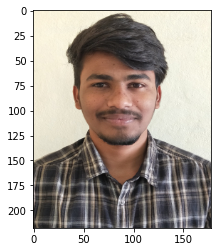

In [7]:
plt.imshow(img)

In [8]:
def dodgeV2(image, mask):
    return cv2.divide(image, 255-mask, scale=256)

In [85]:
def burnV2(image, mask):
    return 255 - cv2.divide(255-image, 255-mask, scale=256)

In [9]:
#img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#ret,thresh1 = cv2.adaptiveThreshold(img,0.60,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
#img = cv2.threshold(img,0.6,1,cv2.THRESH_BINARY)[1]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray_inv = 255 - img_gray
img_blur = cv2.GaussianBlur(img_gray_inv, ksize=(21, 21),sigmaX=0, sigmaY=0)
img_blend = dodgeV2(img_gray, img_blur)
img = cv2.cvtColor(img_blend,cv2.COLOR_GRAY2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


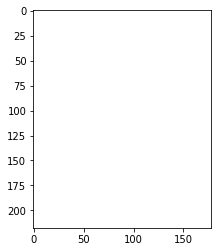

In [10]:
plt.imshow(img)


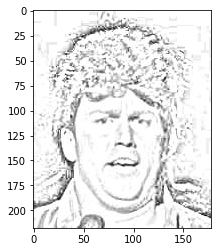

In [134]:
plt.imshow(X[0])

In [134]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
sharpened = cv2.filter2D(img, -1, kernel_sharpening)
#dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


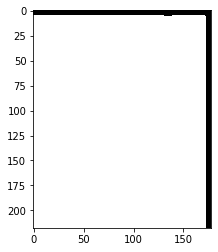

In [111]:
plt.imshow(img)

In [225]:
img.shape

(218, 178, 3)

In [28]:
X,y = val_gen.__getitem__(7)

In [96]:
X.shape

(16, 218, 178, 3)

In [11]:
#y_pred = model.predict(X)
y_pred = model1.predict(img.reshape(1,218,178,3))

1/1 [==============================] - 0s 465ms/step


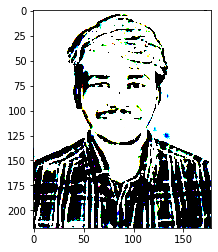

In [12]:
plt.imshow(y_pred[0])

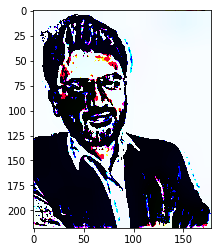

In [112]:


# Load the image
img = y_pred[0]
img = (img * 255).astype(np.uint8)
# Convert the color space from BGR to LAB
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Split the LAB channels
l, a, b = cv2.split(lab)

# Apply a color correction function to the a and b channels
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))

a = clahe.apply(a)
b = clahe.apply(b)

# Merge the corrected channels back into the LAB image
lab = cv2.merge((l, a, b))

# Convert the color space back to BGR
output_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# Save the output image
# cv2.imwrite('output_image.jpg', output_img)
plt.imshow(output_img)


In [77]:
img_test = cv2.imread('skect.png')
img_test = cv2.resize(testing,(178,218))

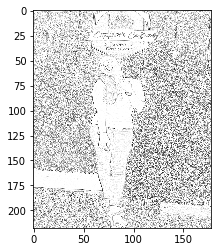

In [78]:
plt.imshow(img_test)

In [79]:
y_pred = model.predict(img_test.reshape(1,218,178,3))

1/1 [==============================] - 0s 73ms/step


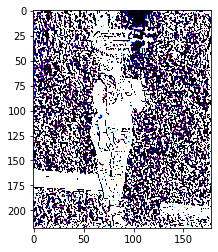

In [80]:
plt.imshow(y_pred[0])

1/1 [==============================] - 1s 667ms/step


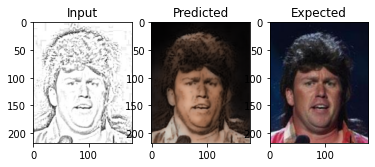

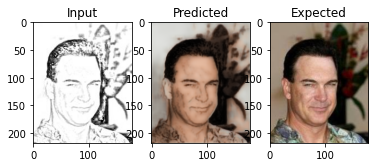

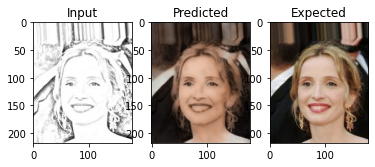

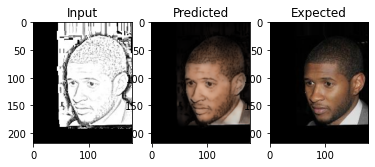

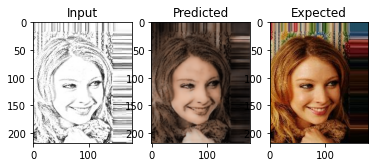

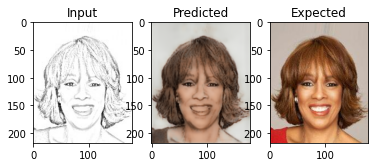

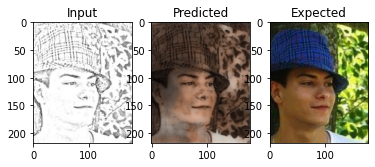

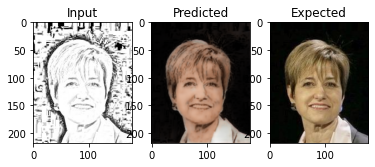

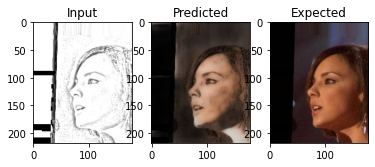

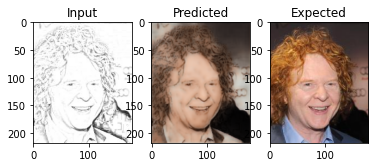

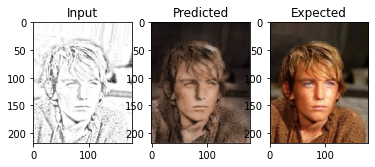

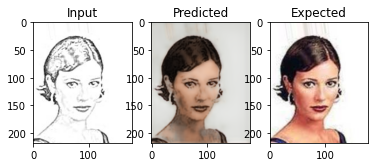

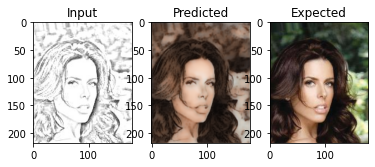

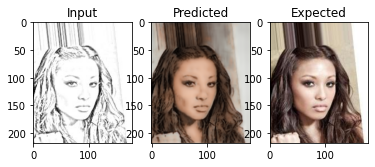

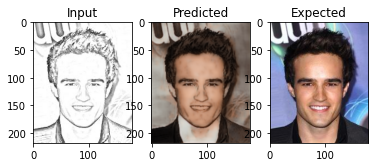

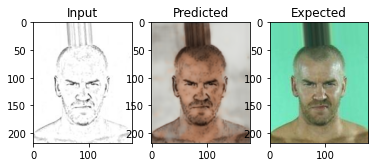

In [109]:
X,y = test_gen.__getitem__(1)
y_pred = model1.predict(X)

for i in range(X.shape[0]):
    f,ax = plt.subplots(1,3)
    ax[0].imshow(X[i])
    ax[0].set_title('Input')
    ax[1].imshow(y_pred[i])
    ax[1].set_title('Predicted')
    ax[2].imshow(y[i])
    ax[2].set_title('Expected')
plt.show()



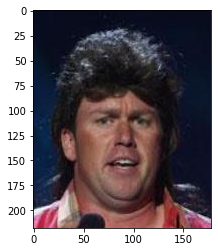

In [136]:
plt.imshow(y[0])
temp = X[0]


In [45]:
#model1.evaluate(test_gen)
len(val_gen)

268

In [34]:
with open('history.pickle','rb') as file:
    history = pickle.load(file)

In [3]:
from keras.models import load_model
model1 = load_model('model.h5',custom_objects={'dice_loss':dice_loss})

In [25]:
#model1.summary()

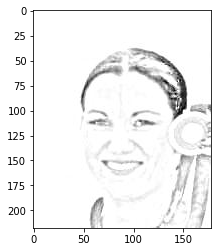

In [141]:
testing1 = X[0]
plt.imshow(testing1)

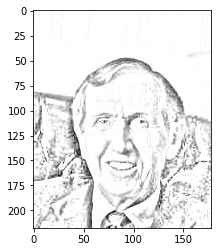

In [142]:
testing3 = X[4]
plt.imshow(testing3)

In [143]:
testing = cv2.imread('001660.jpg')
testing = cv2.resize(testing,(178,218))

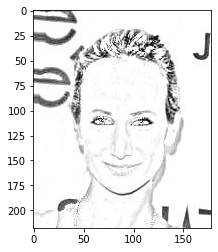

In [144]:
plt.imshow(testing
          )

In [145]:
temp = model1.predict(testing.reshape(1,218,178,3))

1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 218ms/step


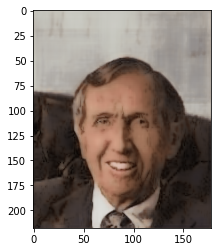

In [146]:
temp1 = model1.predict(testing3.reshape(1,218,178,3))
plt.imshow(temp1[0])

actual


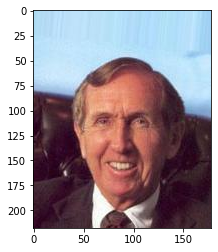

In [147]:
print("actual")
plt.imshow(y[4])

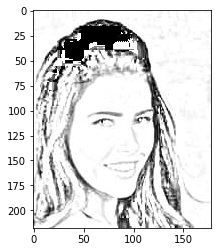

In [148]:
testing4 = X[10]
plt.imshow(testing4)

1/1 [==============================] - 0s 58ms/step


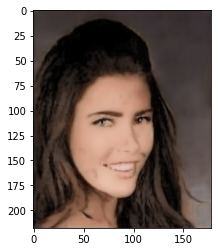

In [149]:
tem4 = model1.predict(testing4.reshape(1,218,178,3))
plt.imshow(tem4[0])

In [233]:
temp[0].shape

(218, 178, 3)

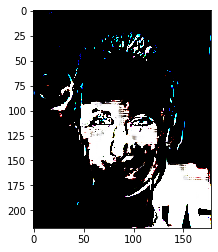

In [150]:
plt.imshow(temp[0])

# Image matching

In [36]:
max(img.flatten())

1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


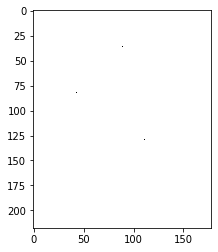

NameError: name 'y_pred' is not defined

In [23]:

plt.imshow(img)
plt.show()
plt.imshow(y_pred[0])
plt.show()

In [151]:
matplotlib.image.imsave('mypic.png',y_pred)

In [52]:
X,y = val_gen.__getitem__(1)
print(len(val_gen))

268


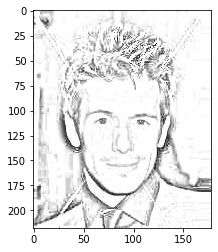

In [56]:
val_t1 = X[0]
plt.imshow(val_t1)

1/1 [==============================] - 0s 81ms/step


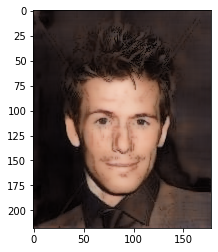

In [60]:
val_t1_pred = model1.predict(val_t1.reshape(1,218,178,3))


Text(0.5, 1.0, 'Expected')

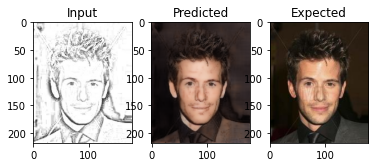

In [62]:
f,ax = plt.subplots(1,3)
ax[0].imshow(val_t1)
ax[0].set_title('Input')
ax[1].imshow(val_t1_pred[0])
ax[1].set_title('Predicted')
ax[2].imshow(y[0])
ax[2].set_title('Expected')

In [73]:
# model1.evaluate(test_gen)

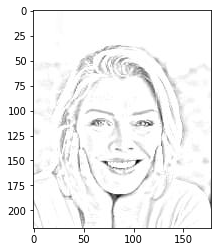

In [72]:
val_t2 = X[15]
plt.imshow(val_t2)

1/1 [==============================] - 0s 69ms/step


Text(0.5, 1.0, 'Expected')

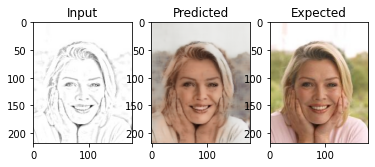

In [75]:
val_t2_pred = model1.predict(val_t2.reshape(1,218,178,3))
f,ax = plt.subplots(1,3)
ax[0].imshow(val_t2)
ax[0].set_title('Input')
ax[1].imshow(val_t2_pred[0])
ax[1].set_title('Predicted')
ax[2].imshow(y[15])
ax[2].set_title('Expected')

In [80]:
X,y = train_gen.__getitem__(1)
print(len(X))

16


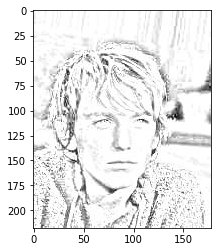

In [120]:
train_t1 = X[10]
plt.imshow(train_t1)

1/1 [==============================] - 0s 52ms/step


Text(0.5, 1.0, 'Expected')

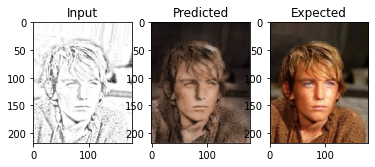

In [121]:
train_t1_pred = model1.predict(train_t1.reshape(1,218,178,3))
f,ax = plt.subplots(1,3)
ax[0].imshow(train_t1)
ax[0].set_title('Input')
ax[1].imshow(train_t1_pred[0])
ax[1].set_title('Predicted')
ax[2].imshow(y[10])
ax[2].set_title('Expected')

In [138]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
checkpoint2 = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,save_weights_only =True,
    save_best_only=True, mode='auto', period=1)
history = model1.fit(train_gen,epochs = epochs,validation_data = val_gen,callbacks=[checkpoint2,checkpoint])

Epoch 1/30
1074/1074 [==============================] - ETA: 0s - loss: 0.5194 - dice_loss: 0.3983 - accuracy: 0.7307
Epoch 1: loss improved from inf to 0.51942, saving model to best_model.hdf5
1074/1074 [==============================] - 4267s 4s/step - loss: 0.5194 - dice_loss: 0.3983 - accuracy: 0.7307 - val_loss: 0.5165 - val_dice_loss: 0.4109 - val_accuracy: 0.7177
Epoch 2/30
1074/1074 [==============================] - ETA: 0s - loss: 0.5169 - dice_loss: 0.3960 - accuracy: 0.7326
Epoch 2: loss improved from 0.51942 to 0.51690, saving model to best_model.hdf5
1074/1074 [==============================] - 5751s 5s/step - loss: 0.5169 - dice_loss: 0.3960 - accuracy: 0.7326 - val_loss: 0.5116 - val_dice_loss: 0.3881 - val_accuracy: 0.7482
Epoch 3/30
1074/1074 [==============================] - ETA: 0s - loss: 0.5145 - dice_loss: 0.3940 - accuracy: 0.7303
Epoch 3: loss improved from 0.51690 to 0.51452, saving model to best_model.hdf5
1074/1074 [==============================] - 4199s 4

Epoch 23/30
1074/1074 [==============================] - ETA: 0s - loss: 0.5032 - dice_loss: 0.3839 - accuracy: 0.7266
Epoch 23: loss did not improve from 0.50203
1074/1074 [==============================] - 4603s 4s/step - loss: 0.5032 - dice_loss: 0.3839 - accuracy: 0.7266 - val_loss: 0.5071 - val_dice_loss: 0.3876 - val_accuracy: 0.7336
Epoch 24/30
1074/1074 [==============================] - ETA: 0s - loss: 0.5014 - dice_loss: 0.3823 - accuracy: 0.7236
Epoch 24: loss improved from 0.50203 to 0.50139, saving model to best_model.hdf5
1074/1074 [==============================] - 4523s 4s/step - loss: 0.5014 - dice_loss: 0.3823 - accuracy: 0.7236 - val_loss: 0.5060 - val_dice_loss: 0.3872 - val_accuracy: 0.7573
Epoch 25/30
1074/1074 [==============================] - ETA: 0s - loss: 0.5012 - dice_loss: 0.3822 - accuracy: 0.7260
Epoch 25: loss improved from 0.50139 to 0.50120, saving model to best_model.hdf5
1074/1074 [==============================] - 4292s 4s/step - loss: 0.5012 - dic